In [1]:
import numpy as np
from time import perf_counter

import pyviztools as pvt
from pyviztools import simple_vts_writer
from pyviztools.ptatin_utils import *
from pyviztools.utils import *

[load_clib] Successfully loaded shared object: viztools.so


In [2]:
import cylin_coor_femesh as demo

Load the data file

In [3]:
mesh, velocity = demo.get_data("/Users/dmay/codes/ptatin3d-pyviztools/step180")
simple_vts_writer("grid.vts", mesh, pointData={"vel": velocity})

-> FEMeshQ1CreateFromPetscVec() execution time: 7.9651e+00 (sec)
Writing file: grid.vts
  vtk field: coor : shape (8520321, 3) : bytes 102243852 : type float32 : C_CONTIGUOUS True
  vtk field: vel : shape (8520321, 3) : bytes 102243852 : type float32 : C_CONTIGUOUS True
-> simple_vts_writer() execution time: 3.4679e-02 (sec)


In [33]:
# Create a new cylinderical mesh.
# This mesh excludes the origin, and crops out most of the domain
# which does not include the dome.
# New mesh defined using
#  radius = [0.01, 0.3]
#  theta  = [0, pi/2]
#  z      = [0, 0.31]
mesh_rtz = demo.build_mesh_rtz(
    64, 64, 64,
    np.array([0.01, 0.0, 0.0],dtype=np.float32),
    np.array([0.3, np.pi/2.0, 0.31],dtype=np.float32))

#rtz_2_xyz = transform_v(mesh_rtz.coor, mesh_rtz.coor, reverse=True)
rtz_2_xyz = np.zeros(mesh_rtz.coor.shape, dtype=np.float32)
rtz_2_xyz[:, 1] = mesh_rtz.coor[:, 2]
rtz_2_xyz[:, 0] = mesh_rtz.coor[:, 0] * np.cos(mesh_rtz.coor[:, 1])
rtz_2_xyz[:, 2] = mesh_rtz.coor[:, 0] * np.sin(mesh_rtz.coor[:, 1])

vel_xyz_p = demo.interpolate(mesh, points=rtz_2_xyz, field=velocity)

# Plot the interpolate velocity on the new grid (coords and vel in x,y,z)
simple_vts_writer("cyl_grid_v.vts", {"coor": rtz_2_xyz,"nodesize": [65, 65, 65]}, pointData={"vel":vel_xyz_p})

vel_rtz_p = demo.transform_v(rtz_2_xyz, vel_xyz_p)

vel_p_ = demo.interpolate(mesh_rtz, points=mesh_rtz.coor, field=vel_rtz_p)
#print('vz_interp/vz_ref', np.max(vel_p_[:,2]), np.max(vel_rtz_p[:,2]))

sr_rtz = demo.compute_strain_rate_rtz(mesh_rtz, vel_p_)
simple_vts_writer("cyl_grid_e_rtz.vts", mesh_rtz, pointData={"v_r":vel_p_[:,0], "v_theta":vel_p_[:,1], "v_z":vel_p_[:,2]}, cellData=sr_rtz)

[interpolate] min el 2
[interpolate] max el 2510601 8388608
Writing file: cyl_grid_v.vts
  vtk field: coor : shape (274625, 3) : bytes 3295500 : type float32 : C_CONTIGUOUS True
  vtk field: vel : shape (274625, 3) : bytes 3295500 : type float32 : C_CONTIGUOUS True
-> simple_vts_writer() execution time: 1.1603e-03 (sec)
[interpolate] min el 0
[interpolate] max el 262143 262144
-> __compute_derivatives() execution time: 4.8675e-02 (sec)
-> __compute_derivatives() execution time: 4.8331e-02 (sec)
-> __compute_derivatives() execution time: 4.8314e-02 (sec)
Writing file: cyl_grid_e_rtz.vts
  vtk field: coor : shape (274625, 3) : bytes 3295500 : type float32 : C_CONTIGUOUS True
  vtk field: e_rr : shape (262144,) : bytes 1048576 : type float32 : C_CONTIGUOUS True
  vtk field: e_tt : shape (262144,) : bytes 1048576 : type float32 : C_CONTIGUOUS True
  vtk field: e_zz : shape (262144,) : bytes 1048576 : type float32 : C_CONTIGUOUS True
  vtk field: e_rt : shape (262144,) : bytes 1048576 : typ

---

Extract a slice defined in terms of nodes.
We extract 
- all nodes in radial directions;
- all nodes in theta direction;
- nodes 4 and 5 in z direction.

In [74]:
z_index = 4
_c2d, _n2d, _cell2d, _ = mesh_rtz.extract_subset([0, mesh_rtz.m+1], [0, mesh_rtz.n+1], [z_index,z_index+2], cellData=sr_rtz)
slice_rtz = pvt.FEMeshQ1(3, _n2d[0]-1, _n2d[1]-1, _n2d[2]-1)
slice_rtz.create_e2v()
slice_rtz.create_coor()

-> extract_subset() execution time: 4.6541e-03 (sec)


In [75]:
slice_rtz.coor[:,:] = _c2d[:, :] 
slice_coor = femesh_get_cell_centroids(slice_rtz)

In [76]:
# debug
print(slice_coor.shape)
print(slice_coor)

(4096, 3)
[[0.01226562 0.01227185 0.02179688]
 [0.01679687 0.01227185 0.02179688]
 [0.02132813 0.01227185 0.02179688]
 ...
 [0.28867188 1.5585245  0.02179688]
 [0.29320312 1.5585245  0.02179688]
 [0.29773438 1.5585245  0.02179688]]


In [77]:
# debug
print(_cell2d['e_rr'].shape)

(4096,)


Plot raw data as points (demo / debugging)

In [78]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


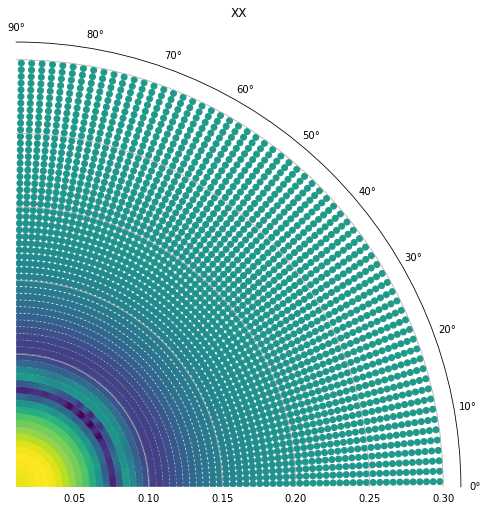

In [79]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(nrows=2, ncols=2)

_ax = fig.add_subplot(gs[0, 0], projection='polar'); # Axis for row 0, col 0.
_ax.set_rorigin(0.01);
_ax.set_thetamin(0.0);
_ax.set_thetamax(90.0);
_p = _ax.scatter(slice_coor[:,1], slice_coor[:,0], c=_cell2d['e_rr'], label='e_rr');
_ax.set_title('XX'); # or plt.title()

Plot data via pcolor (demo)

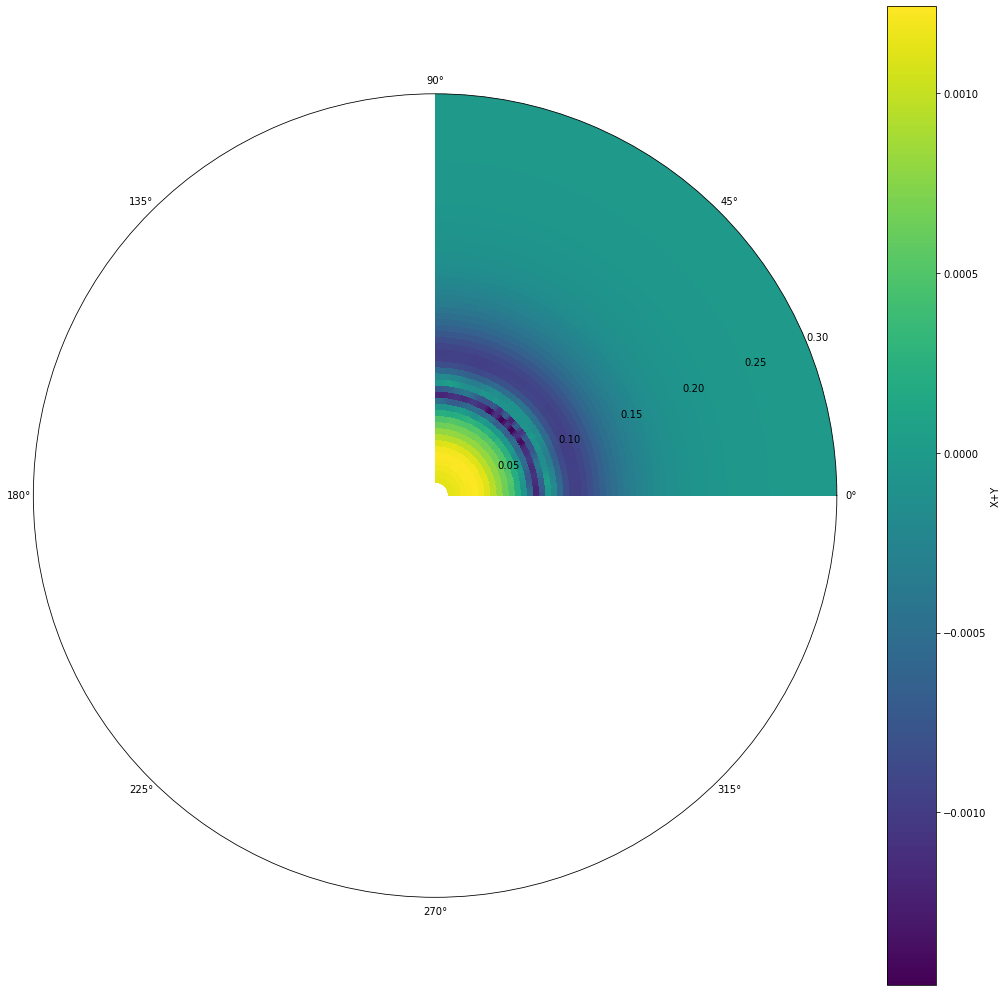

In [80]:
_r2d = np.reshape(np.copy(slice_coor[:,0]), (_n2d[0]-1,_n2d[1]-1))
_t2d = np.reshape(np.copy(slice_coor[:,1]), (_n2d[0]-1,_n2d[1]-1))

fig = plt.figure(figsize=(18, 18))
_ax = fig.add_subplot(projection='polar')
_f2d = np.reshape(np.copy(_cell2d['e_rr']), (_n2d[0]-1,_n2d[1]-1))
_ax.grid(False)
_p = _ax.pcolor(_t2d, _r2d, _f2d)
cb = fig.colorbar(_p, ax=_ax);
cb.set_label('X+Y')

Create nice figure

In [81]:
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

/var/folders/bk/kq7dttkd11364kdrntcd0_q80000gq/T/ipykernel_24961/3645538917.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be

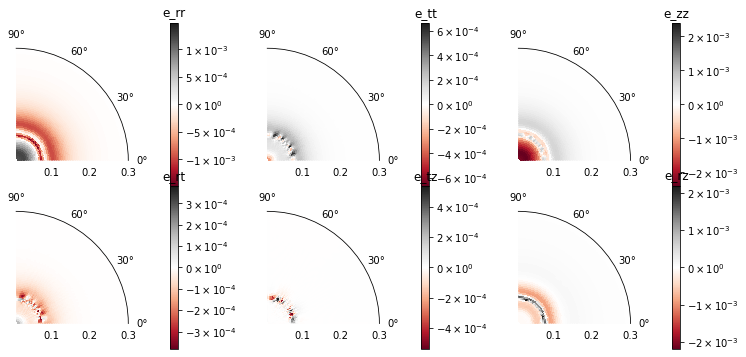

In [83]:
_r2d = np.reshape(np.copy(slice_coor[:,0]), (_n2d[0]-1,_n2d[1]-1))
_t2d = np.reshape(np.copy(slice_coor[:,1]), (_n2d[0]-1,_n2d[1]-1))

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(nrows=2, ncols=3, wspace=0.5, hspace=0.0)

keys = list(_cell2d.keys())

index, index_i, index_j = 0, 0, 0

for key in keys:
    _f2d = np.reshape(np.copy(_cell2d[key]), (_n2d[0]-1,_n2d[1]-1))
    rr = np.max( np.absolute(_cell2d[key]) )
    
    _ax = fig.add_subplot(gs[index_i, index_j], projection='polar'); # Axis for row 0, col 0.
    _ax.set_rorigin(0.01);
    _ax.set_rmax(0.2);
    _ax.set_thetamin(0.0);
    _ax.set_thetamax(90.0);
    _ax.grid(False)
    _p = _ax.pcolor(_t2d, _r2d, _f2d, vmin=-rr, vmax=rr, cmap='RdGy')
    cb = fig.colorbar(_p, ax=_ax, fraction=0.08, pad=0.25, format=ticker.FuncFormatter(fmt))
    #cb.set_label(key, rotation=0, loc='top')
    cb.ax.set_title(key)
    index += 1
    index_j += 1
    if index == 3:
        index_i = 1
        index_j = 0
    

plt.tight_layout()
plt.savefig('ee.pdf')